In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import os
from torchvision.datasets import ImageFolder


- Develop a machine learning system to detect defects in can images.  
- Train the model on labeled images of defective and non-defective cans.  
- Deploy the system with a user-friendly frontend interface.  
- Allow users to upload images for defect classification.

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


1. Data augmentation (flip, rotate, crop) helps the model generalize better and reduces overfitting.  
2. Normalization scales pixel values for stable and efficient training.




In [4]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip images
    transforms.RandomRotation(degrees=15),   # Rotate images by ±15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Adjust brightness and contrast
    transforms.RandomResizedCrop(size=128, scale=(0.8, 1.0)),  # Randomly crop and resize
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])


In [ ]:
!unzip 'Cans_data.zip'

In [6]:
data_dir = "/content/Cans_data"

# Load train dataset with augmentation
dataset = ImageFolder(root=data_dir, transform=transform)


In [7]:
dataset.classes

['defect', 'no_defect']

In [8]:

# Split dataset (80% train, 20% test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Use a different (non-augmented) transform for test dataset
test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Apply transform to test dataset
test_dataset.dataset.transform = test_transform

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


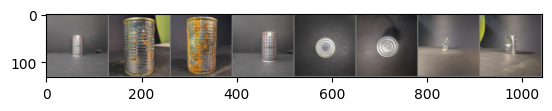

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Function to denormalize and display images
def imshow(img):
    img = img / 2 + 0.5  # Denormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[:8]))  # Show first 8 images


In [10]:
class DefectClassifier(nn.Module):
    def __init__(self):
        super(DefectClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, 2)  # 2 classes: "defect" and "no_defect"
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize model
model = DefectClassifier().to(device)
print(model)


DefectClassifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)


In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {train_acc:.2f}%")


Epoch [1/10], Loss: 0.7116, Accuracy: 59.15%
Epoch [2/10], Loss: 0.3440, Accuracy: 84.76%
Epoch [3/10], Loss: 0.2915, Accuracy: 89.63%
Epoch [4/10], Loss: 0.1445, Accuracy: 92.68%
Epoch [5/10], Loss: 0.0767, Accuracy: 96.95%
Epoch [6/10], Loss: 0.0564, Accuracy: 98.17%
Epoch [7/10], Loss: 0.0171, Accuracy: 99.39%
Epoch [8/10], Loss: 0.0075, Accuracy: 100.00%
Epoch [9/10], Loss: 0.0034, Accuracy: 100.00%
Epoch [10/10], Loss: 0.0010, Accuracy: 100.00%


In [13]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = 100 * correct / total
print(f"Test Accuracy: {test_acc:.2f}%")


Test Accuracy: 95.24%


In [14]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np


Classification Report:
               precision    recall  f1-score   support

      defect       0.94      0.94      0.94        17
   no_defect       0.96      0.96      0.96        25

    accuracy                           0.95        42
   macro avg       0.95      0.95      0.95        42
weighted avg       0.95      0.95      0.95        42



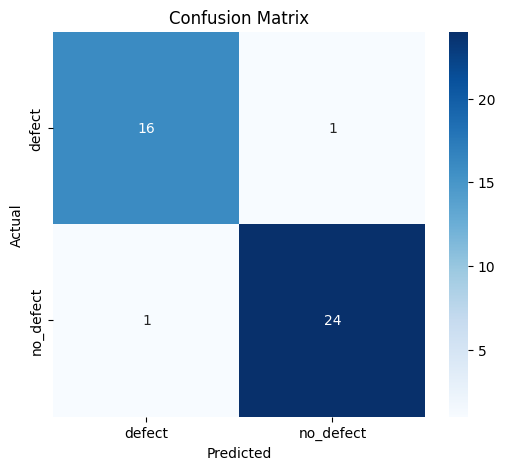

In [15]:
# Put model in evaluation mode
model.eval()

class_names = dataset.classes

# Initialize lists for predictions and actual labels
all_preds = []
all_labels = []

# Disable gradient computation for testing
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Get model predictions
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Store predictions & actual labels
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert lists to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Print classification report (Precision, Recall, F1-Score)
print("Classification Report:\n", classification_report(all_labels, all_preds, target_names=class_names))

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


The model performed well, achieving 95% accuracy in classifying defects. Both Defective and Non-Defective classes had high precision and recall (~94-96%), indicating balanced performance with minimal misclassification.

Test Model Perfomanc with image

In [23]:
from PIL import Image

def predict_image(image_path, model, transform):
    model.eval()  # Ensure model is in eval mode

    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    # Get prediction
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)

    return class_names[predicted.item()]  # Get class label

# Example usage
test_image_path = "/content/Cans_data/defect/IMG_20220709_191034_jpg.rf.98783524a04c612ba679a599bfe3c228.jpg"
prediction = predict_image(test_image_path, model, test_transform)
print(f"Predicted Class: {prediction}")


Predicted Class: defect


In [24]:
torch.save(model.state_dict(), "defect_detection_model_working.pth")
print("Model saved successfully!")

Model saved successfully!
